In [2]:
%pylab --no-import-all inline
from scipy.fftpack import fft, ifft
import pyglet.media.avbin
import scipy

Populating the interactive namespace from numpy and matplotlib


Loading audio data...
AudioFormat(channels=2, sample_size=16, sample_rate=44100)
4
Pulling out the first 1MB of audio data.
Complete!
2123529812.0
-2138262471.0


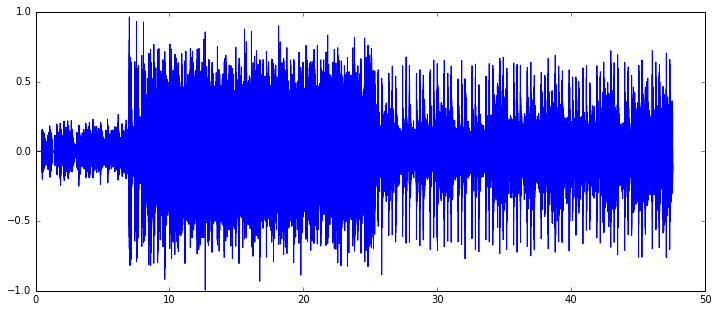

In [3]:
print 'Loading audio data...'
audioFile = pyglet.media.avbin.AVbinSource("C:\\input.mp3")
print audioFile.audio_format
print audioFile.audio_format.bytes_per_sample
print 'Pulling out the first 1MB of audio data.'
buffer_size = 8 << 20
buffer = ''
duration = 0
while buffer_size > 0:
    audioData = audioFile.get_audio_data(buffer_size);
    buffer += audioData.data
    duration += audioData.duration
    buffer_size -= audioData.length
print 'Complete!'

npData = np.frombuffer(buffer, dtype=np.int32).reshape((-1,2)).astype(dtype=np.float)
npTimeCode = np.linspace(0, duration, num=npData.shape[0], dtype=np.float)

print npData.max()
print npData.min()
npData = np.divide(npData, np.iinfo(np.int32).max)
plt.figure(figsize=(12, 5))
plt.plot(npTimeCode, npData[:,0])

#npData is a Nx2 matrix of audio data...



In [17]:
import io
class NpAudioSource(pyglet.media.Source):
    def __init__(self, source, audio_format):
        self.audio_format = audio_format
        self.buff = source
        self.buffPos = 0
        self.buffLen = source.shape[0] * self.audio_format.bytes_per_sample * self.audio_format.channels
        self._duration = float(self.buffLen) / self.audio_format.bytes_per_second
        print 'Creating AudioSource, Duration %f' % self._duration
    
    def get_audio_data(self, bytes):
        timestamp = float(self.buffPos) / self.audio_format.bytes_per_second
        
        # Align to sample size
        if self.audio_format.bytes_per_sample == 2:
            bytes &= 0xfffffffe
        elif self.audio_format.bytes_per_sample == 4:
            bytes &= 0xfffffffc

        remainingBytes = self.buffLen - self.buffPos
        toRead = min(remainingBytes, bytes)
        if (toRead == 0): return None
        
        duration = toRead / self.audio_format.bytes_per_second
           
        currPos = self.buffPos / (self.audio_format.bytes_per_sample * self.audio_format.channels)
        endPos = (self.buffPos + toRead) / (self.audio_format.bytes_per_sample * self.audio_format.channels) 
        
        data = np.array(self.buff[currPos:endPos])
        data = np.multiply(data, np.iinfo(np.int32).max).astype(dtype=np.int32).flatten().tostring()
        
        self.buffPos += toRead

        #print 'getting %d bytes, timestamp %f, buff_pos %d!' % (len(data), timestamp, self.buffPos)
        return pyglet.media.AudioData(data, len(data), timestamp, duration, [])

def playNp(np):
    NpAudioSource(np, audioFile.audio_format).play()

npSmall = npData[1:44100,:]
playNp(npSmall)

Creating AudioSource, Duration 1.999955


# Some notes on FFT
- We use rfft because our data is entirely in the real domain.
- We use a hanning window to minimize noise from spectral leakage.
- The frequency of each bucket is k cycles per N samples.
- To get to audial freq: 
 - sample_rate = samples per second
 - frequency = cycles per second 
 - (cycles/samples) * (samples/sec) => cycles/sec

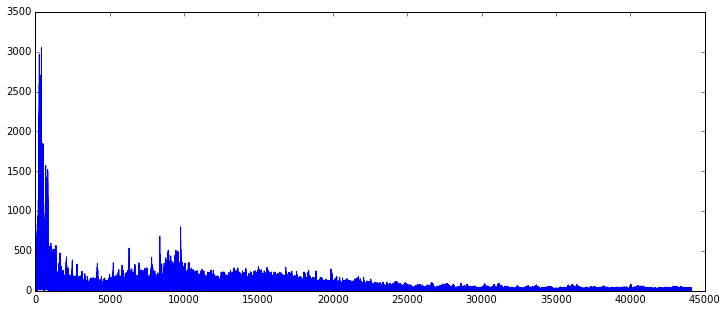

In [16]:

#channel = npSmall[:, 0]
channel = npData[:,0]
yf = np.fft.rfft(np.hanning(channel.shape[0]) * (channel))
xf = np.linspace(0.0, float(audioFile.audio_format.sample_rate), yf.shape[0])
plt.figure(figsize=(12,5))
plt.plot(xf, np.abs(yf))



## STFT

- http://stackoverflow.com/questions/2459295/invertible-stft-and-istft-in-python
- Wavelet transforms also show a lot of promise here, but might be premature:
  https://en.wikipedia.org/wiki/Wavelet_transform

[-0.58179866+0.j          0.54669151+0.40213307j -0.98742397-0.65413735j
 ..., -0.92475499-1.62170448j -0.98742397+0.65413735j
  0.54669151-0.40213307j]
-6.00005379761
7.81693913448


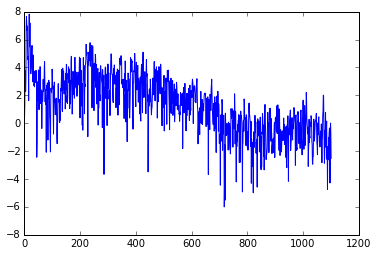

In [20]:
framesamp = int(0.05*44100)
w = scipy.hamming(framesamp)

windowed = w * channel[400000:400000+framesamp]

fftOut = scipy.fft(windowed)
print fftOut

toPlot = np.log(np.square(np.abs(fftOut[1:fftOut.size / 2])))

print toPlot.min()
print toPlot.max()
plt.plot(toPlot)




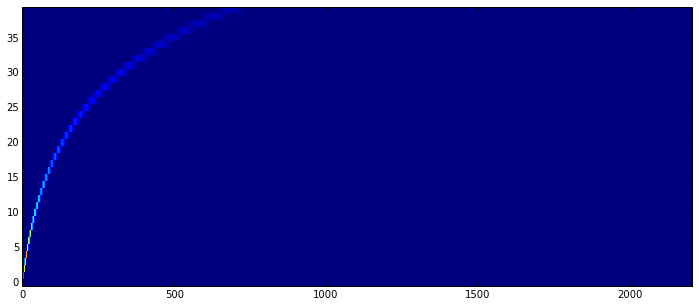

In [33]:
# Mel Frequency Bands

def buildMel(f_s, f_Hzmin, f_Hzmax, K, M):
    toMel = lambda f: 1127 * np.log(1 + f / 700)
    toHz = lambda f: 700 * (np.exp(f / 1127) - 1)
    
    f_min = toMel(f_Hzmin)
    f_max = toMel(f_Hzmax)
    f_width = (f_max - f_min) / (M + 1)
    f_c = lambda m: f_min + f_width * m
    k_c = lambda m: toHz(f_c(m)) * K / f_s

    # Goal: Build F(m,k) matrix for m = 0..39 and k 0..K
    M_out = np.zeros((M, K))
    def normalizedMel(m, k):
        if k > k_c(m - 1) and k <= k_c(m):
            return 2 * (k - k_c(m-1)) / (k_c(m+1)-k_c(m-1)) / (k_c(m)-k_c(m-1))
        elif k > k_c(m) and k < k_c(m+1):
            return 2 * (k_c(m+1) - k) / (k_c(m+1)-k_c(m-1)) / (k_c(m+1)-k_c(m))
        else:
            return 0.0

    for k in range(int(K)):
        for m in range (int(M)):
            M_out[m, k] = normalizedMel(m, k)
    return M_out
    
M = buildMel(44100.0, 20.0, 16000.0, 2205, 40)

plt.figure().set_size_inches(12, 5)
plt.imshow(M_out, origin='lower', aspect='auto',
             interpolation='nearest')


framesamp 2205
2205
44100
1048896
19683.9222345
0.0
16.9912791407


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:27: RuntimeWarning: divide by zero encountered in log


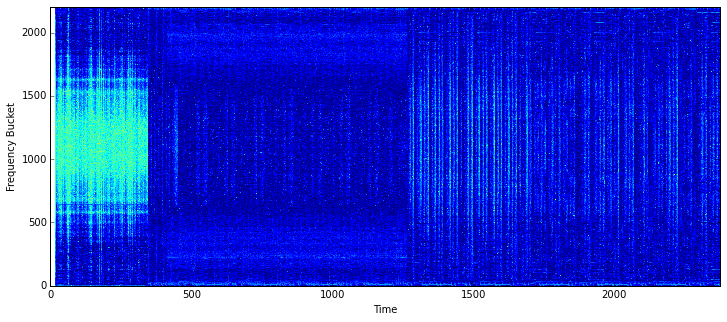

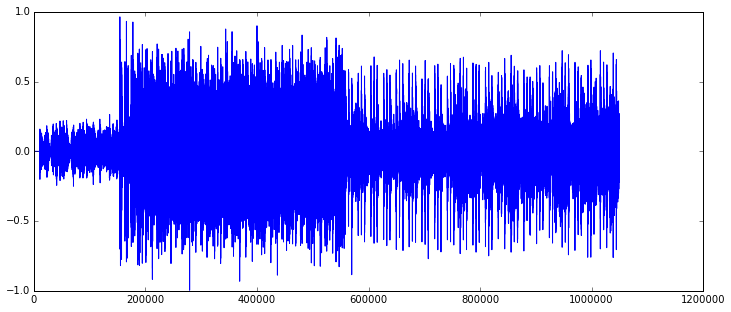

In [24]:
import scipy, pylab

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    print 'framesamp %d' % framesamp
    w = scipy.hamming(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
        
# 16 samples a second?


X = stft(channel, audioFile.audio_format.sample_rate, 0.050, 0.010)
X = np.abs(X)

#np.savetxt("C:\\Users\\andre_000\\before.csv", X, delimiter=",")
X = np.square(X)
toPlot = np.log(X)
#np.savetxt("C:\\Users\\andre_000\\after.csv", X, delimiter=",")

plt.figure().set_size_inches(12, 5)
plt.imshow(scipy.absolute(toPlot.T), origin='lower', aspect='auto',
             interpolation='nearest')
plt.xlabel('Time')
plt.ylabel('Frequency Bucket')

plt.figure().set_size_inches(12, 5)
plt.plot(channel)

print X[0].size 
#(2205)
print audioFile.audio_format.sample_rate
print channel.size

print X.max()
print X.min()
print X.mean()

np.savetxt("C:\\Users\\andre_000\\meh.csv", channel, delimiter=",")

MinVal -inf, MaxVal 9.887557


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log


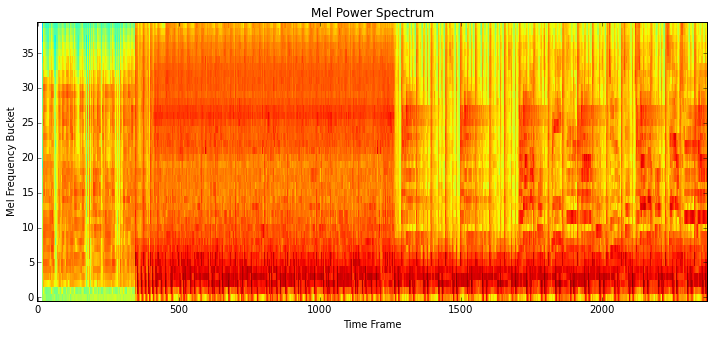

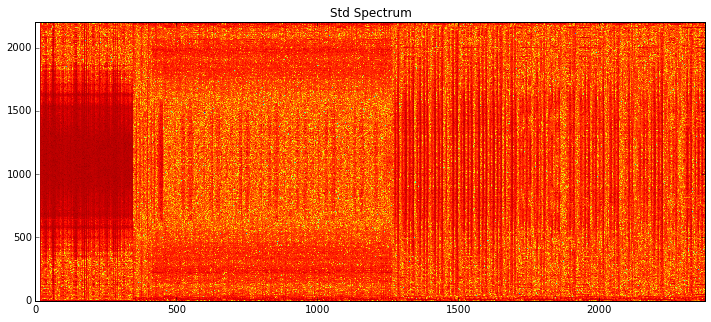

In [59]:
M_out = np.empty((X.shape[0], M.shape[0]))

X_power = np.square(X)
for i in range(X.shape[0]):
    M_out[i, :] = np.sum(X_power[i, :] * M, axis=1)
    
plt.figure().set_size_inches(12, 5)
plt.title("Mel Power Spectrum")
plt.ylabel("Mel Frequency Bucket")
plt.xlabel("Time Frame")
plt.imshow(np.log(M_out.T), origin='lower', aspect='auto', interpolation='nearest')

plt.figure().set_size_inches(12, 5)
plt.title("Std Spectrum")
plt.imshow(np.log(scipy.absolute(toPlot.T)), origin='lower', aspect='auto',
    interpolation='nearest')

print "MinVal %f, MaxVal %f" % (float(toPlot.min()), float(toPlot.max()))

## Work by others
https://code.soundsoftware.ac.uk/users/22
Matthew Davies knows what's up.

http://vamp-plugins.org/
http://aubio.org/


## Building a corpus of music

* Build a small app to manually tag muisc with beat data
* Store the data itself in mongoDB perhaps?
